## Cloning Quasars

Let's look at the redshift distribution of quasars in the SDSS survey.

> To start, download the quasar data

In [128]:
from astroML.datasets import fetch_dr7_quasar

data = fetch_dr7_quasar()

z = data['redshift']

> Upsample this distribution using the rejection sampling method

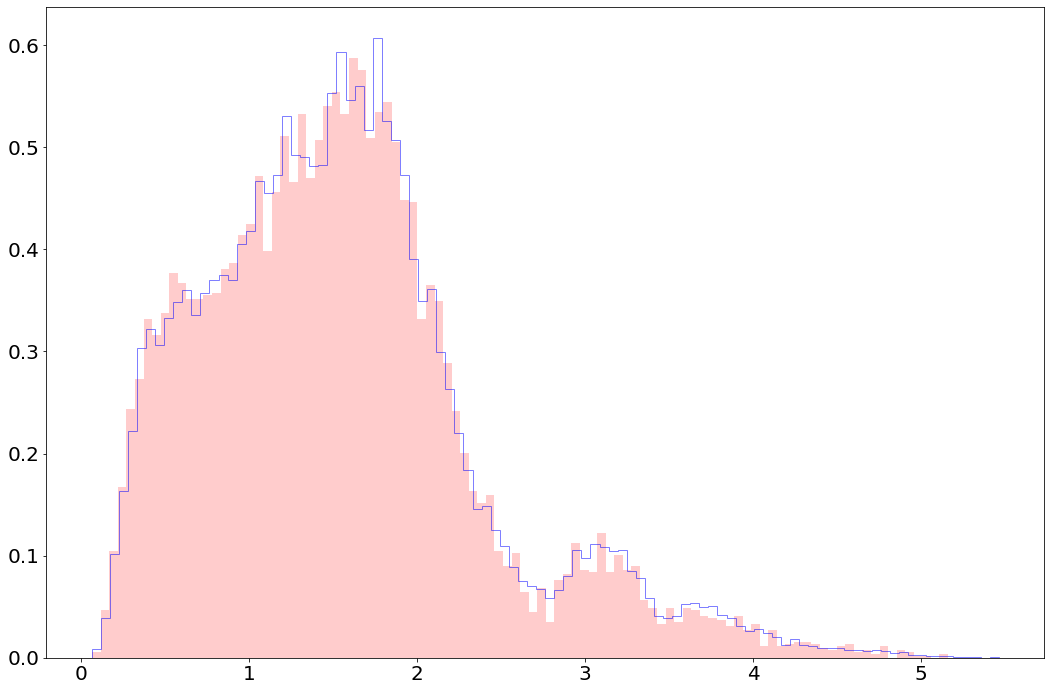

In [117]:
z = data['redshift']   # Re-Select the data just to avoid making a mess later

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['font.size'] = 20

nBins = 100

caps, edges = np.histogram(z, bins=nBins, density=True)
means = 0.5*edges[:-1]+edges[1:]*0.5

# Rejection Sampling
top = np.max(z)
bot = np.min(z)
N = 10000
X = np.zeros(N)

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

i = 0
while i < N:
    y = np.random.uniform(0, top*1.1)
    x = np.random.uniform(bot, top)
    idx = np.where(means == find_nearest(means, x))
    if y < caps[idx] :
        X[i] = x
        i+=1

plt.hist(z, bins=nBins, density=True, color='b', alpha=0.5, histtype='step')
plt.hist(X, bins=nBins, density=True, color='r', alpha=0.2)
plt.tight_layout()

# prova a usare questo:
from scipy.stats import rv_histogram

> Upsample this distribution using the inverse transform method

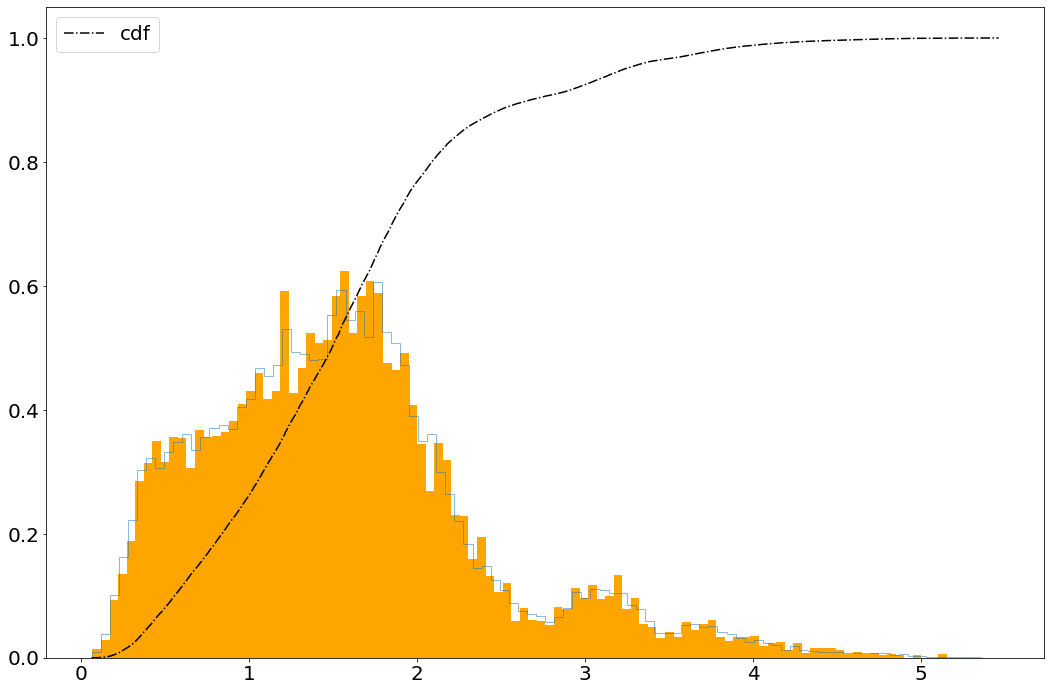

In [130]:
z = data['redshift'] # reset per sicurezza, going to remove quando ho finito.

from scipy import stats, interpolate

z.sort()
plt.hist(z, density=True, bins=nBins, histtype='step', alpha=0.5)

def ecdf(a):
    x, counts = np.unique(a, return_counts=True)
    cusum = np.cumsum(counts)
    return x, cusum / cusum[-1]

my_z, my_ecdf = ecdf(z)
plt.plot(my_z, my_ecdf, ls='-.', label='cdf', c='k')
plt.legend()

inverse_cdf = interpolate.interp1d(my_ecdf, my_z)

u = np.random.uniform(1e-9,1-1e-9,N)
Y = inverse_cdf(u)
plt.hist(Y, density=True, bins=nBins, color='orange')
plt.tight_layout()

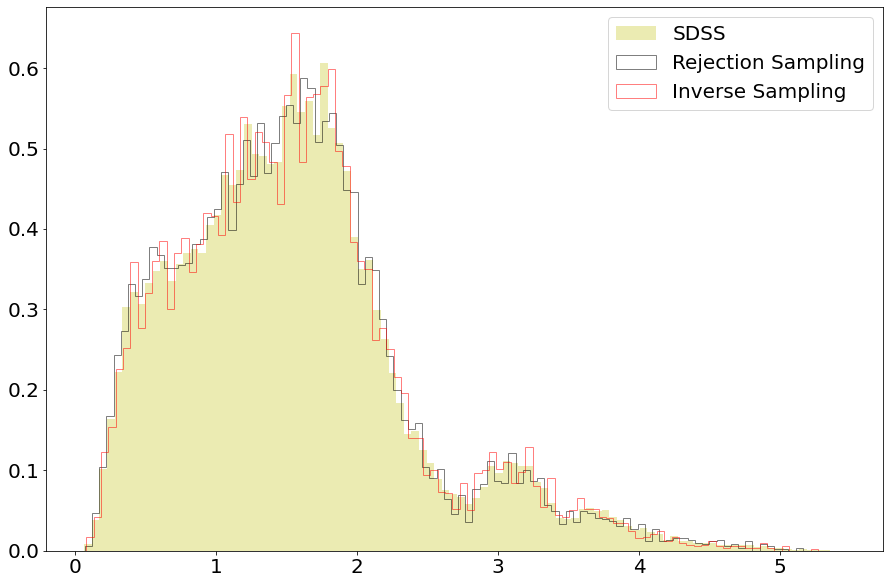

In [119]:
# Check, at least visually, that the two cloned distributions are similar to the observed one 

plt.hist(z, density=True, bins=nBins, color='y', alpha=0.3, label='SDSS')#, histtype='step' )
plt.hist(X, density=True, bins=nBins, color='k', alpha=0.5, histtype='step', label='Rejection Sampling' )
plt.hist(Y, density=True, bins=nBins, color='r', alpha=0.5, histtype='step', label='Inverse Sampling' )
plt.legend(loc='best')

## Work in progress below

Let's assume that QSO's are uniformly distributed in a comoving volume of the universe. 

> What is the uniform QSO distribution going to look like? Does it match with the SDSS data?

To start, one can make use of the *Planck15* parameters to set u

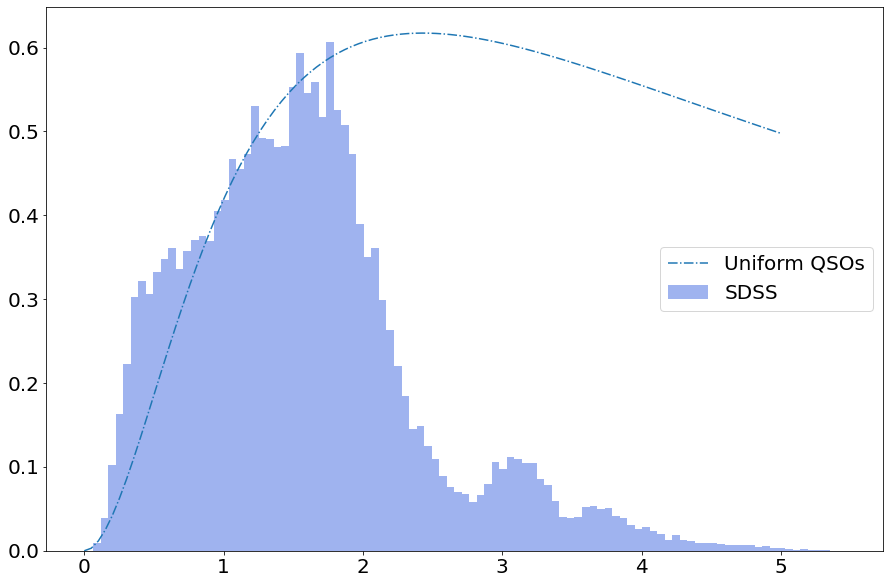

In [126]:
import astropy.cosmology as cosmo
from scipy.integrate import quad

class uniformredshift(object):
    def __init__(self,zmax):
        ''' Lazy loading...'''
        self._norm = None
        self._pdfmax = None
        self.zmax=zmax

    def _eval(self,z_vals):
        '''Unnormalized pdf'''
        return ((4.*np.pi*cosmo.Planck15.differential_comoving_volume(z_vals).value))
        # è un volume comovente in Mpc-3 diviso sr ( per unità di angolo solido, immagino )
        # prende solo il .value ma è tutto ok

    def norm(self):
        '''Compute normalization'''
        if self._norm is None:
            self._norm = quad( self._eval, 0, self.zmax )[0]
        return self._norm
        # questo viene calcolato una volta sola, quando la norma è zero. 
        # altrimenti, norm è semplicemente 'rimandato' a self._norm

    def eval(self,z_vals):
        return self._eval(z_vals)/self.norm()

        return np.array(zsample)
    
redshiftpdf = uniformredshift(zmax = 5)
# Lazy Loading: creo l'oggetto ma non lo 'riempio' fino a quando non serve.

z = np.linspace(0,5,100)
plt.plot(z, 2.45*redshiftpdf.eval(z), label='Uniform QSOs', ls='-.') 
###   Arbitrary normalization, just matching by eye
# il metodo eval tira fuori un array di frequenze: alla fine della fiera è una pdf
# continuo a non aver ben chiaro come funziona il codice dentro la classe >_<

h_data = plt.hist(data['redshift'], bins=nBins, density=True, label='SDSS', color='royalblue', alpha=0.5)
plt.legend(loc='center right')

The mis-match between the histogram and the distribution from SDSS can be explained with a *selection rule* in the observation of QSOs in the night sky: as objects get farther away from Earth, they become harder to detect. The problem of *incompleteness* thus can be invoked to explain the discrepancy between the actual data and its expected values.